# MLA project: Learning to detect dysarthria from raw speech

*Authors: Louis Simon Bastien Dussard, Fabien Pichon, Marc Favier*

This notebook pertains at showing our architecture inspired from Millet  and Zeghidour's paper *(Juliette  Millet  and  Neil  Zeghidour.   Learning  to  detect  dysarthria  from  raw  speech.arXiv:1811.11101 ,January 2019. http://arxiv.org/abs/1811.11101)*.

First, you need to download the data by loading the following Google Drive folder on your own drive and then choose the right path to unzip the data and functions. This requires you to run this notebook on google colab.

**Link to .zip file**: https://drive.google.com/drive/folders/1ugjZJU89F8Dzxl5_kr93CnPfIhYeBqNf?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/MLA_dysarthria/notebook.zip

Archive:  gdrive/My Drive/MLA_dysarthria/notebook.zip
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: blocks.py               
  inflating: evaluate_model.py       
  inflating: full_lld_is09_test.npy  
  inflating: full_lld_is09_train.npy  
  inflating: full_lld_is09_val.npy   
  inflating: model.py                
  inflating: pcen_test.npy           
  inflating: pcen_train.npy          
  inflating: pcen_val.npy            
  inflating: time_mfb.py             
  inflating: weights_LLD.h5          
  inflating: weights_melfilt.h5      
  inflating: weights_td_filt.h5      
  inflating: x_test.npy              
  inflating: x_train.npy             
  inflating: x_val.npy               
  inflating: y_test.npy              


The training procedure utilizes the same script for training each variants of the model. This script can be found in the `__main__()` function of `model.py`. In this notebook, we will load and evaluate model using functions from `model_evaluate.py`

## Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse

In [2]:
from model import build_model
from evaluate_model import visualize_attention

In [3]:
x_test_lld = np.load("full_lld_is09_test.npy")
x_test_mel = np.load("pcen_test.npy").transpose([0,2,1])
x_test_td = np.load("x_test.npy")

x_val_lld = np.load("full_lld_is09_val.npy")
x_val_mel = np.load("pcen_val.npy").transpose([0,2,1])
x_val_td = np.load("x_val.npy")


y_test = np.load("y_test.npy")
y_test = tf.keras.utils.to_categorical(y_test.astype(int),num_classes=2)
y_val = np.load("y_val.npy")
y_val = tf.keras.utils.to_categorical(y_val.astype(int),num_classes=2)

In [4]:
#defining the parser
parser = argparse.ArgumentParser(
        usage=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter)

parser.add_argument('-frontEnd',choices=["TDfilt","melfilt","LLD"],nargs='?',type=str,default="melfilt")
parser.add_argument('-normalization',choices=["log","mvn","pcen","learn_pcen","none"],nargs='?',type=str,default="log")
parser.add_argument('-lr',nargs='?',type=float,default=0.0001)
parser.add_argument('-batch_size',nargs='?',type=int,default=32)
parser.add_argument('-epochs',nargs='?',type=int,default=5)
parser.add_argument('-decay',nargs='?',type=bool,default=False)

_StoreAction(option_strings=['-decay'], dest='decay', nargs='?', const=None, default=False, type=<class 'bool'>, choices=None, help=None, metavar=None)

## Testing LLD

In [5]:
args = parser.parse_args(['-frontEnd', 'LLD'])
model_lld = build_model(args,tf.keras.optimizers.SGD())
model_lld.load_weights("./weights_LLD.h5")
model_lld.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 251, 32)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 251, 60)      22320       ['input[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 251, 50)      3050        ['lstm[0][0]']                   
                                                                                                  
 dropout (Dropout)              (None, 251, 50)      0           ['dense[0][0]']                  
                                                                                              

In [19]:
_, _ , test_uar_lld = model_lld.evaluate(x_test_lld,y_test,batch_size=1)
_, _, val_uar_lld = model_lld.evaluate(x_val_lld,y_val,batch_size=1)
print("Validation UAR : {:.2f} %, Test UAR : {:.2f} %".format(val_uar_lld*100,test_uar_lld*100))

1752/1752 [==============================] - 78s 44ms/step - loss: 0.5388 - binary_accuracy: 0.7529 - uar_metric: 0.6244
Validation UAR : 62.44 %, Test UAR : 62.79 %


## Testing mel-filters

In [6]:
args = parser.parse_args(['-frontEnd', 'melfilt','-normalization','pcen'])
model_mel = build_model(args,tf.keras.optimizers.SGD())
model_mel.load_weights("./weights_melfilt.h5")
model_mel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 251, 64)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 251, 60)      30000       ['input[0][0]']                  
                                                                                                  
 dense_3 (Dense)                (None, 251, 50)      3050        ['lstm_1[0][0]']                 
                                                                                                  
 dropout_2 (Dropout)            (None, 251, 50)      0           ['dense_3[0][0]']                
                                                                                            

In [14]:
_, _ , test_uar_mel = model_mel.evaluate(x_test_mel,y_test,batch_size=1)
_, _, val_uar_mel = model_mel.evaluate(x_val_mel,y_val,batch_size=1)
print("Validation UAR : {:.2f} %, Test UAR : {:.2f} %".format(val_uar_mel*100,test_uar_mel*100))

1752/1752 [==============================] - 73s 42ms/step - loss: 0.7115 - binary_accuracy: 0.7146 - uar_metric: 0.6276
Validation UAR : 62.76 %, Test UAR : 73.73 %


## Testing TD-filterbanks

In [7]:
args = parser.parse_args(['-frontEnd', 'TDfilt'])
model_td = build_model(args,tf.keras.optimizers.SGD())
model_td.load_weights("./weights_td_filt.h5")
model_td.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 40000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 39601, 128)   51328       ['input[0][0]']                  
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 39601, 64)   0           ['conv1d[0][0]']                 
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 39601, 64)   0           ['conv1d[0][0]']           

In [9]:
_, _ , test_uar_td = model_td.evaluate(x_test_td,y_test,batch_size=1)
_, _, val_uar_td = model_td.evaluate(x_val_td,y_val,batch_size=1)
print("Validation UAR : {:.2f} %, Test UAR : {:.2f} %".format(val_uar_td*100,test_uar_td*100))

1752/1752 [==============================] - 88s 50ms/step - loss: 0.4283 - binary_accuracy: 0.8154 - uar_metric: 0.6624
Validation UAR : 66.24 %, Test UAR : 70.48 %


**Analysing mel-filters approximation using TD-filterbanks**

One can see that, even with few epochs (300 out of 2000), the TD-filterbank model is able to at least reproduce mel-spectrograms with well-located peaks of energy. 

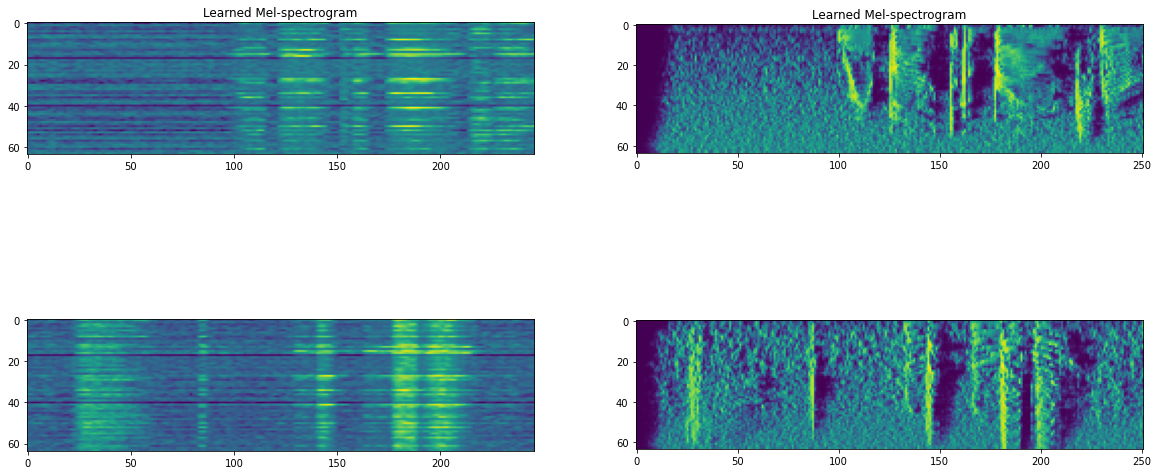

In [38]:
idx = np.random.randint(low=0,high=len(y_test),size=2)

func = tf.keras.backend.function(model_td.input,model_td.layers[10].output)
mel_td0 = func(x_test_td[idx[0]][np.newaxis])[0].transpose([1,0])
mel_td1 = func(x_test_td[idx[1]][np.newaxis])[0].transpose([1,0])

_, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
ax[0,0].imshow(np.flipud(mel_td0))
ax[0,0].set_title("Learned Mel-spectrogram")
ax[1,0].imshow(np.flipud(mel_td1))

ax[0,1].imshow(x_test_mel[idx[0]].transpose([1,0]))
ax[0,1].set_title("Learned Mel-spectrogram")
ax[1,1].imshow(x_test_mel[idx[1]].transpose([1,0]))

plt.show()

## Visualizing attention vector

Predicted class :  0


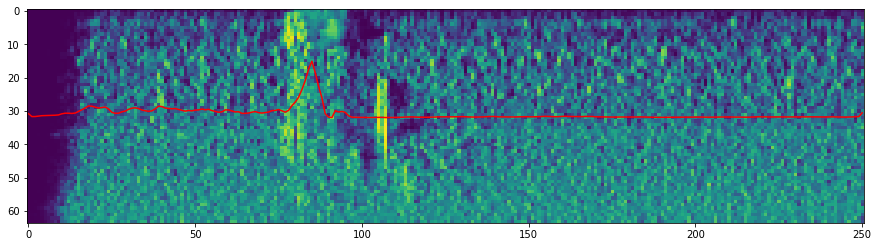

Predicted class :  0


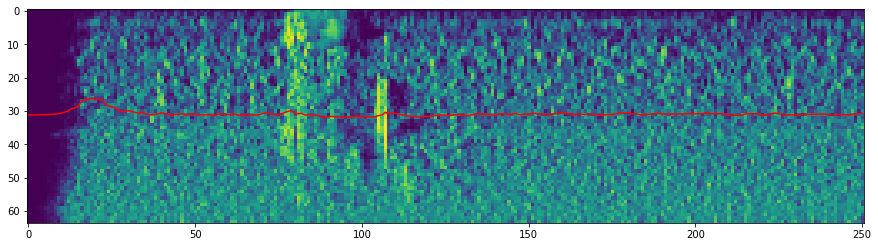

Predicted class :  0


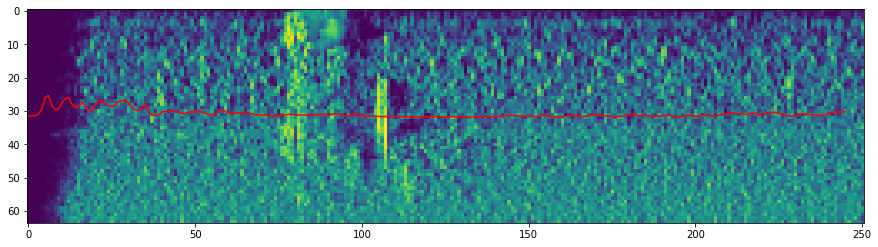

In [8]:
idx = np.random.randint(low=0,high=len(y_test))
pcen = x_test_mel[idx].transpose([1,0])

x = x_test_lld[idx]
visualize_attention(x,pcen,model_lld,"LLD")

x = x_test_mel[idx].transpose([1,0])
visualize_attention(x,pcen,model_mel,"melfilt")

x = x_test_td[idx]
visualize_attention(x,pcen,model_td,"TDfilt")